# Supervised Learning Final Project

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from scipy.spatial import distance
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
import scipy.stats
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from numpy import array
import copy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
jobs = 10

# 1. Load and explore the dataset. Eventually perform data engineering (handling missing values, encoding categorical values, ...).

In [3]:
def scalerandencoder(df, scaler):
    df_train_float = df.select_dtypes(exclude="object")
    coll = df_train_float.columns
    df_train_float = scaler.transform(df_train_float)
    df_train_float = pd.DataFrame(df_train_float)
    # renaming the columns after the scaling
    df_train_float.columns = coll

    # Encoding the categorical part of the dataset
    df_train_cat = df.select_dtypes(include="object")
    id_train = df_train_cat["ID"]
    df_train_cat.drop("ID", axis=1, inplace=True)
    ord_enc = OrdinalEncoder()
    df_train_cat["Attack"] = ord_enc.fit_transform(df_train_cat[["Attack"]])
    df_train_cat["Deadly"] = ord_enc.fit_transform(df_train_cat[["Deadly"]])
    df_train_cat["Gormiti_Land"] = ord_enc.fit_transform(df_train_cat[["Gormiti_Land"]])
    deadly = df_train_cat["Deadly"]
    attack = df_train_cat["Attack"]
    land = df_train_cat["Gormiti_Land"]
    df_train_cat.drop("Deadly", axis=1, inplace=True)
    df_train_cat.drop("Attack", axis=1, inplace=True)
    df_train_cat.drop("Gormiti_Land", axis=1, inplace=True)
    df_train_cat = pd.get_dummies(df_train_cat)
    df_train_cat["Attack"] = attack
    df_train_cat["Deadly"] = deadly
    df_train_cat["Gormiti_Land"] = land
    df = pd.concat([df_train_cat, df_train_float], axis=1)
    return df

def outlierdropper(df):
    colmn = df.columns
    for i in colmn:
        if df[i].dtype == 'float64' or df[i].dtype == 'int64':
            k = 2.5
            upper = df[i].mean() + df[i].std() * k
            lower = df[i].mean() - df[i].std() * k
            df = df[(df[i] < upper) & (df[i] > lower)]
    return df

In [4]:
df_train = pd.read_csv("Gormiti_train.csv")
df_test = pd.read_csv("Gormiti_test.csv")
df_train

,Unnamed: 0,ID,Gormiti_Type,Nature,Deadly,Growth_rate,Attack,Strength,Ray,Ability,Against_Fire,Against_Meka,Against_Lava,Against_Wind,Against_Rock,Gormiti_Land
0,0,580a08ea-4db6-46ba-b5f1-21f8dfcfa2b0,Fire,Evil,Yes,Slow,Yes,59.0,Omega,stalagmites,-1.020907,-0.198581,-2.994943,-1.596865,-0.164760,Iceland
1,1,efdc2c72-834e-44d3-acf1-8b83a6bd0760,Fire,Evil,No,Medium,Yes,40.0,Beta,Dark bullets,-1.671520,-0.516204,0.600385,0.116257,0.550372,Windland
2,2,e3878403-c13b-4f6f-8e87-a1e72ea2e71c,Wind,Evil,Yes,Fast,Yes,52.0,Alpha,Dark bullets,1.374496,-0.498522,0.097014,2.162580,-1.017195,Iceland
3,3,1d5c102b-47a9-40fd-80b9-96ab8d7b2b7b,Wind,Evil,No,Medium,No,36.0,Alpha,Meka energy,-0.340917,-1.741547,-1.269091,-1.211137,-2.840029,Rockland
4,4,8093fb82-8692-4352-b213-e4d18074fc18,Rock,Good,No,Medium,Yes,58.0,Gamma,whirlwind,1.472178,-1.313746,-1.670818,-2.643774,0.991630,Fireland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7995,0c50046e-8397-4ac1-a528-f87654a912ef,Aoki,Good,No,Medium,No,41.0,Gamma,Burning energy,0.723469,-1.909741,0.671805,0.080248,-0.690939,Rockland
7996,7996,64ceeaa4-a419-4e46-b1cc-b8befa447eb3,Sea,Good,Yes,Medium,No,41.0,Gamma,whirlwind,2.070754,0.348883,-1.141936,-1.845884,1.022508,Fireland
7997,7997,e28f5bfe-c2a2-4bf8-b699-1f00b1f50bbb,Fearsome Darkens,Evil,No,Slow,Yes,55.0,Omega,whirlwind,1.733139,-0.468651,2.065541,-0.648536,-3.644766,Windland
7998,7998,9ddc67a9-d8b7-416e-8ed1-195b6ac9dc5e,Sea,Evil,Yes,Medium,No,50.0,Gamma,Magical light power,-0.951960,2.022711,-3.837023,3.000448,-2.363179,Iceland


In [5]:
df_train = df_train.drop("Unnamed: 0", axis=1)
df_test = df_test.drop("Unnamed: 0", axis=1)
df_train

,ID,Gormiti_Type,Nature,Deadly,Growth_rate,Attack,Strength,Ray,Ability,Against_Fire,Against_Meka,Against_Lava,Against_Wind,Against_Rock,Gormiti_Land
0,580a08ea-4db6-46ba-b5f1-21f8dfcfa2b0,Fire,Evil,Yes,Slow,Yes,59.0,Omega,stalagmites,-1.020907,-0.198581,-2.994943,-1.596865,-0.164760,Iceland
1,efdc2c72-834e-44d3-acf1-8b83a6bd0760,Fire,Evil,No,Medium,Yes,40.0,Beta,Dark bullets,-1.671520,-0.516204,0.600385,0.116257,0.550372,Windland
2,e3878403-c13b-4f6f-8e87-a1e72ea2e71c,Wind,Evil,Yes,Fast,Yes,52.0,Alpha,Dark bullets,1.374496,-0.498522,0.097014,2.162580,-1.017195,Iceland
3,1d5c102b-47a9-40fd-80b9-96ab8d7b2b7b,Wind,Evil,No,Medium,No,36.0,Alpha,Meka energy,-0.340917,-1.741547,-1.269091,-1.211137,-2.840029,Rockland
4,8093fb82-8692-4352-b213-e4d18074fc18,Rock,Good,No,Medium,Yes,58.0,Gamma,whirlwind,1.472178,-1.313746,-1.670818,-2.643774,0.991630,Fireland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0c50046e-8397-4ac1-a528-f87654a912ef,Aoki,Good,No,Medium,No,41.0,Gamma,Burning energy,0.723469,-1.909741,0.671805,0.080248,-0.690939,Rockland
7996,64ceeaa4-a419-4e46-b1cc-b8befa447eb3,Sea,Good,Yes,Medium,No,41.0,Gamma,whirlwind,2.070754,0.348883,-1.141936,-1.845884,1.022508,Fireland
7997,e28f5bfe-c2a2-4bf8-b699-1f00b1f50bbb,Fearsome Darkens,Evil,No,Slow,Yes,55.0,Omega,whirlwind,1.733139,-0.468651,2.065541,-0.648536,-3.644766,Windland
7998,9ddc67a9-d8b7-416e-8ed1-195b6ac9dc5e,Sea,Evil,Yes,Medium,No,50.0,Gamma,Magical light power,-0.951960,2.022711,-3.837023,3.000448,-2.363179,Iceland


In [6]:
df_train.describe()

,Strength,Against_Fire,Against_Meka,Against_Lava,Against_Wind,Against_Rock
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,50.966750,0.484189,-0.986843,-0.513012,-0.517482,-0.518231
std,9.484666,1.636463,1.235982,1.575095,1.711674,1.552168
min,35.000000,-6.116688,-6.403020,-6.592109,-6.670034,-7.065428
25%,43.000000,-0.573518,-1.730210,-1.621934,-1.697078,-1.560249
50%,51.000000,0.600012,-0.991274,-0.434169,-0.659360,-0.630650
75%,59.000000,1.607006,-0.232497,0.718957,0.491765,0.466300
max,67.000000,5.744405,4.300767,4.589191,6.687927,5.479101


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            8000 non-null   object 
 1   Gormiti_Type  8000 non-null   object 
 2   Nature        8000 non-null   object 
 3   Deadly        8000 non-null   object 
 4   Growth_rate   8000 non-null   object 
 5   Attack        8000 non-null   object 
 6   Strength      8000 non-null   float64
 7   Ray           8000 non-null   object 
 8   Ability       8000 non-null   object 
 9   Against_Fire  8000 non-null   float64
 10  Against_Meka  8000 non-null   float64
 11  Against_Lava  8000 non-null   float64
 12  Against_Wind  8000 non-null   float64
 13  Against_Rock  8000 non-null   float64
 14  Gormiti_Land  8000 non-null   object 
dtypes: float64(6), object(9)
memory usage: 937.6+ KB


In [8]:
df_train.isnull().sum()

ID              0
Gormiti_Type    0
Nature          0
Deadly          0
Growth_rate     0
Attack          0
Strength        0
Ray             0
Ability         0
Against_Fire    0
Against_Meka    0
Against_Lava    0
Against_Wind    0
Against_Rock    0
Gormiti_Land    0
dtype: int64

In [9]:
df_train.duplicated(keep=False).sum()

0

C:\Users\Gabri\AppData\Local\Temp\ipykernel_18000\3331440802.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  relation = df_train.corr()


<AxesSubplot: >

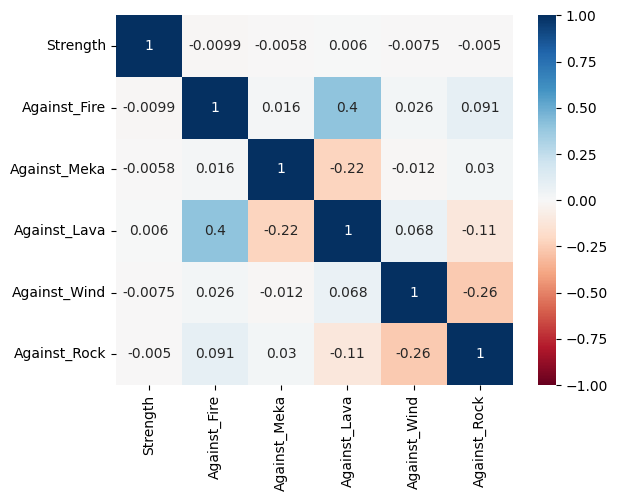

In [10]:
relation = df_train.corr()
sns.heatmap(relation,cmap = 'RdBu',vmin=-1, vmax=1, annot = True)

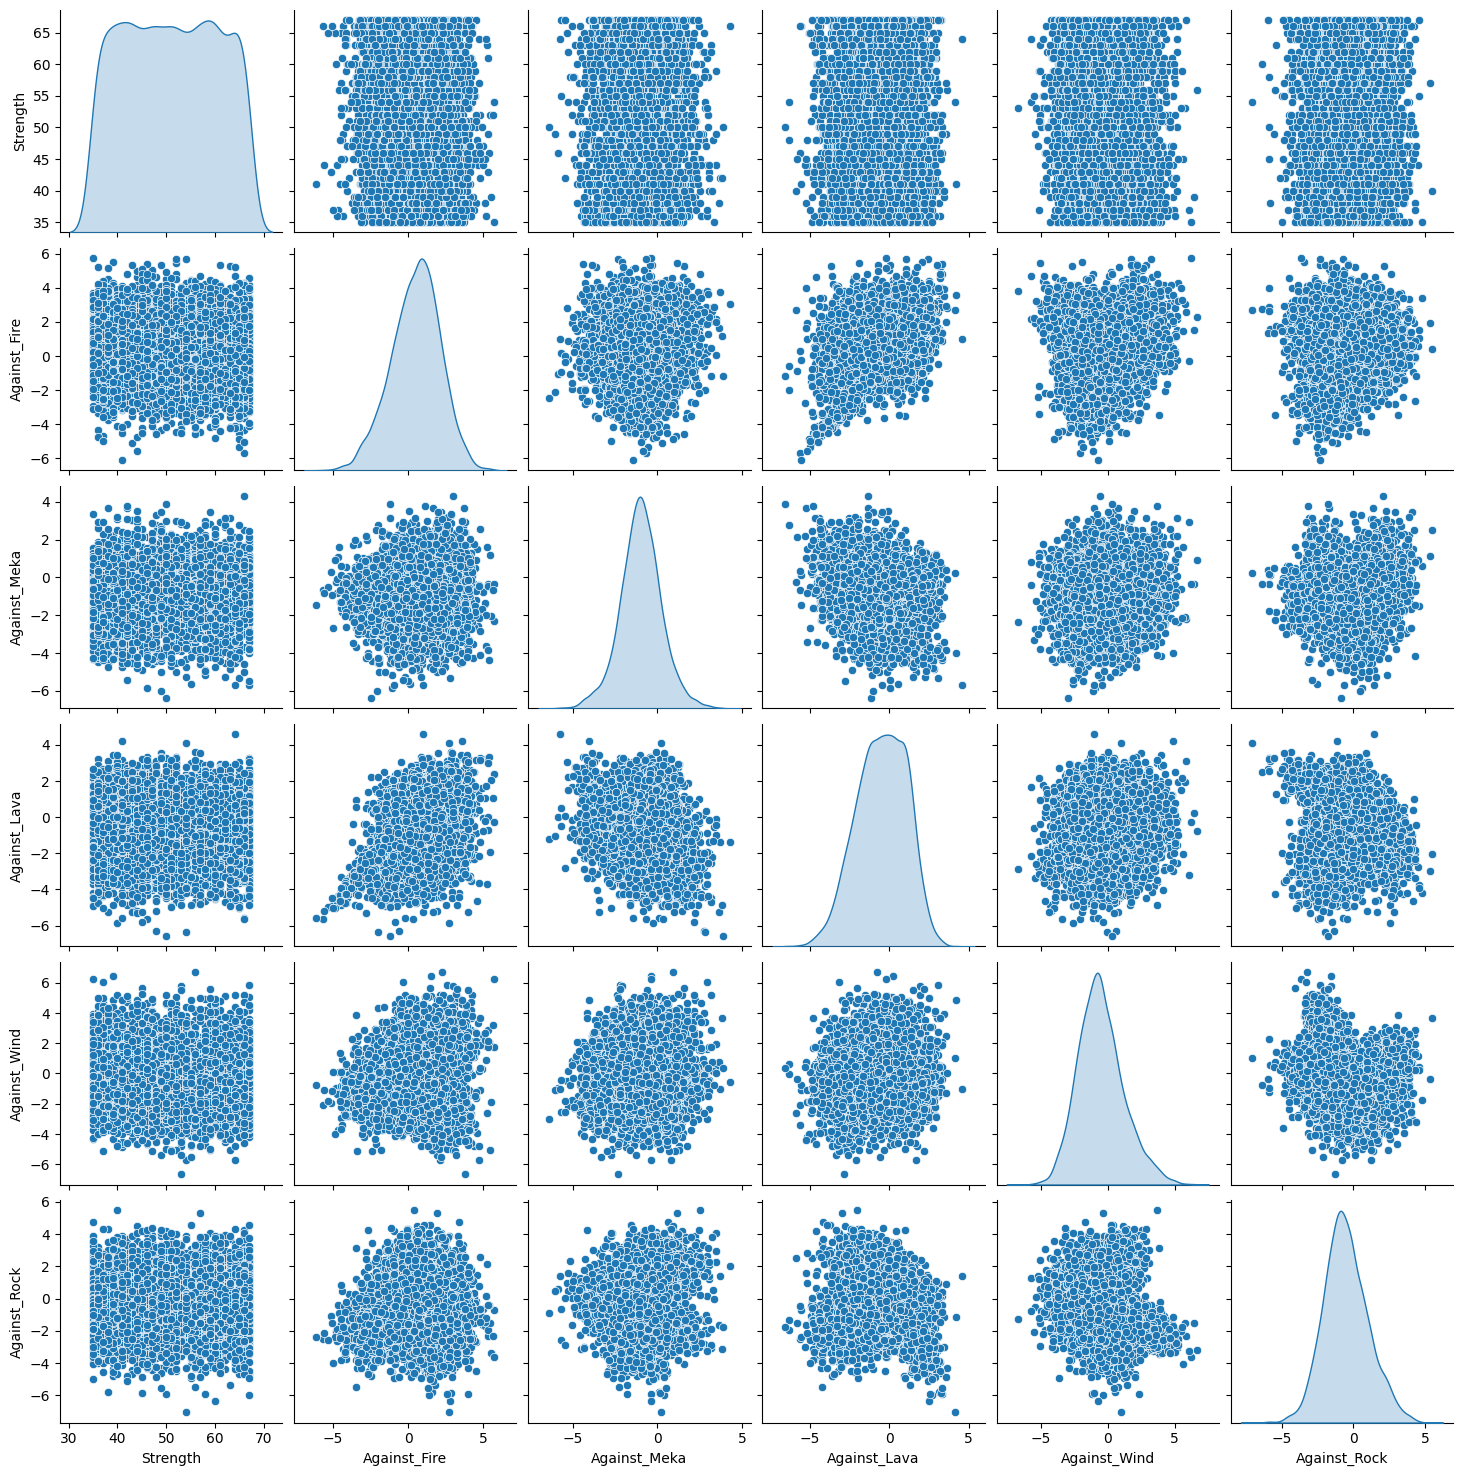

In [11]:
sns.pairplot(data=df_train,kind='scatter',diag_kind='kde')

In [12]:
# Scaler creation
df_train_float = df_train.select_dtypes(exclude="object")
scaler = preprocessing.RobustScaler().fit(df_train_float)

# Aplying the scaler
df_train = scalerandencoder(df_train, scaler)
df_train

,Gormiti_Type_Aoki,Gormiti_Type_Fearsome Darkens,Gormiti_Type_Fire,Gormiti_Type_Ice,Gormiti_Type_Lava,Gormiti_Type_Meka,Gormiti_Type_Rock,Gormiti_Type_Sea,Gormiti_Type_Wind,Nature_Evil,...,Ability_whirlwind,Attack,Deadly,Gormiti_Land,Strength,Against_Fire,Against_Meka,Against_Lava,Against_Wind,Against_Rock
0,0,0,1,0,0,0,0,0,0,1,...,0,1.0,1.0,1.0,0.5000,-0.743362,0.529269,-1.093931,-0.428311,0.229893
1,0,0,1,0,0,0,0,0,0,1,...,0,1.0,0.0,3.0,-0.6875,-1.041737,0.317197,0.441948,0.354350,0.582775
2,0,0,0,0,0,0,0,0,1,1,...,0,1.0,1.0,1.0,0.0625,0.355183,0.329003,0.226915,1.289239,-0.190740
3,0,0,0,0,0,0,0,0,1,1,...,0,0.0,0.0,2.0,-0.9375,-0.431515,-0.500946,-0.356668,-0.252086,-1.090218
4,0,0,0,0,0,0,1,0,0,0,...,1,1.0,0.0,0.0,0.4375,0.399980,-0.215310,-0.528282,-0.906604,0.800514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,2.0,-0.6250,0.056618,-0.613246,0.472458,0.337899,-0.029750
7996,0,0,0,0,0,0,0,1,0,0,...,1,0.0,1.0,0.0,-0.6250,0.674490,0.894802,-0.302350,-0.542078,0.815750
7997,0,1,0,0,0,0,0,0,0,1,...,1,1.0,0.0,3.0,0.2500,0.519658,0.348947,1.067845,0.004945,-1.487315
7998,0,0,0,0,0,0,0,1,0,1,...,0,0.0,1.0,1.0,-0.0625,-0.711742,2.012391,-1.453657,1.672029,-0.854916


In [13]:
df_test = scalerandencoder(df_test, scaler)
df_test

,Gormiti_Type_Aoki,Gormiti_Type_Fearsome Darkens,Gormiti_Type_Fire,Gormiti_Type_Ice,Gormiti_Type_Lava,Gormiti_Type_Meka,Gormiti_Type_Rock,Gormiti_Type_Sea,Gormiti_Type_Wind,Nature_Evil,...,Ability_whirlwind,Attack,Deadly,Gormiti_Land,Strength,Against_Fire,Against_Meka,Against_Lava,Against_Wind,Against_Rock
0,1,0,0,0,0,0,0,0,0,1,...,0,0.0,1.0,1.0,0.0000,-0.081704,-1.128760,0.670409,1.172530,0.013587
1,0,0,1,0,0,0,0,0,0,1,...,0,0.0,1.0,2.0,0.5625,0.318732,-0.285525,0.702507,0.471454,0.091061
2,0,1,0,0,0,0,0,0,0,0,...,0,0.0,0.0,1.0,-0.5625,-0.995494,1.215173,-1.383018,0.831031,-0.174036
3,1,0,0,0,0,0,0,0,0,1,...,0,0.0,0.0,2.0,0.5000,-0.897623,-0.093824,-0.220525,-0.132251,0.417568
4,0,0,0,0,0,1,0,0,0,0,...,1,1.0,0.0,0.0,0.0625,-0.535627,-1.850058,-0.226290,-0.266482,0.109068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,1,0,0,0,...,0,0.0,0.0,3.0,-0.6250,-0.854314,0.932500,0.501818,-0.508428,0.442736
1996,0,0,0,0,0,0,0,0,1,0,...,1,0.0,0.0,1.0,-0.6875,-0.168735,0.330441,-0.189781,0.332767,-0.474369
1997,0,0,0,1,0,0,0,0,0,1,...,0,0.0,0.0,2.0,-0.7500,0.071541,0.041819,0.552553,-0.431034,0.303377
1998,0,0,0,0,0,0,0,1,0,0,...,0,0.0,1.0,3.0,0.8750,-0.183466,0.759577,1.064780,0.158560,-1.055982


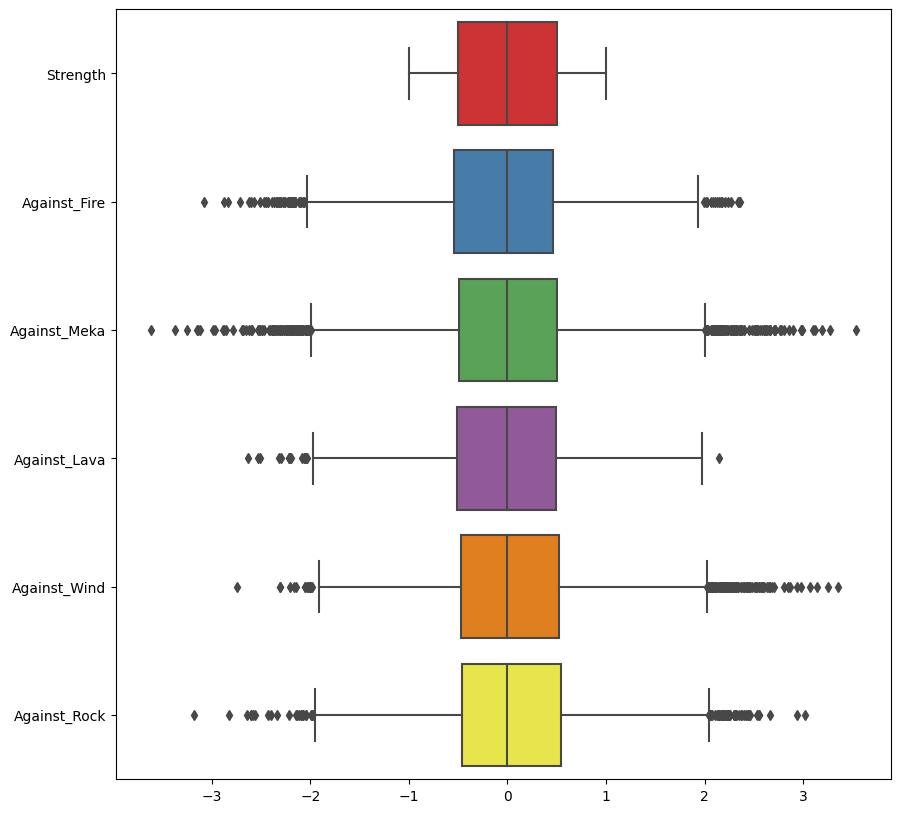

In [14]:
df_temp = df_train.iloc[:,-6:]
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df_temp, orient="h", palette="Set1")

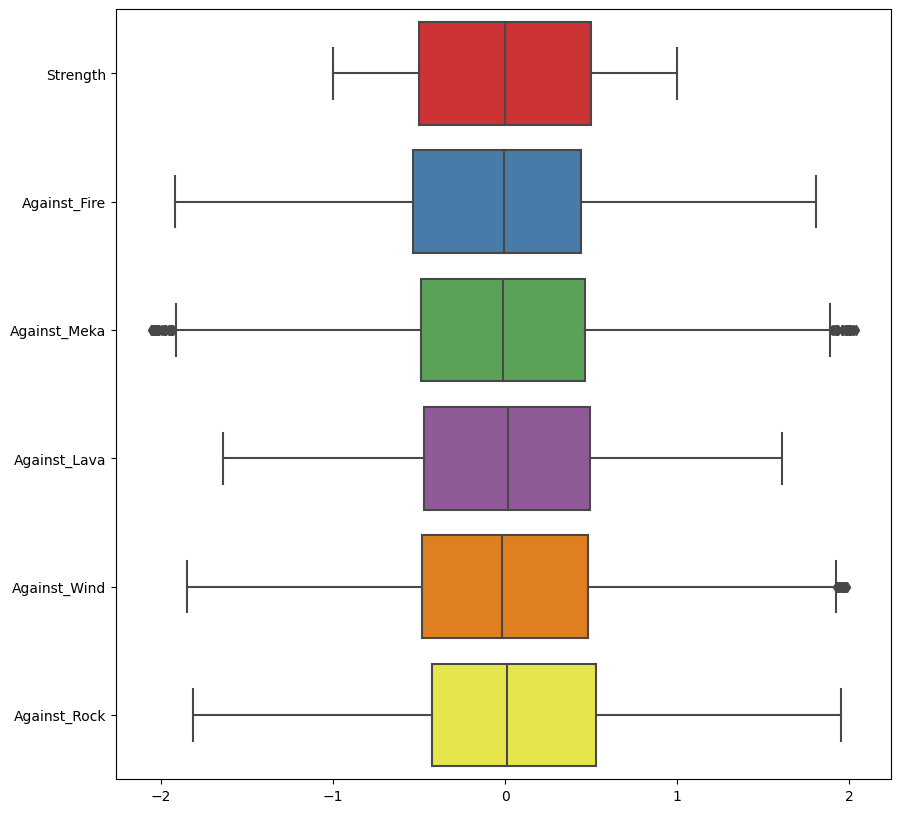

In [15]:
df_train = outlierdropper(df_train)
df_temp = df_train.iloc[:,-6:]
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df_temp, orient="h", palette="Set1")

### Splitting the datasets

In [16]:
y_train = df_train["Gormiti_Land"]
X_train = df_train.drop("Gormiti_Land", axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=22)

In [17]:
X_val

,Gormiti_Type_Aoki,Gormiti_Type_Fearsome Darkens,Gormiti_Type_Fire,Gormiti_Type_Ice,Gormiti_Type_Lava,Gormiti_Type_Meka,Gormiti_Type_Rock,Gormiti_Type_Sea,Gormiti_Type_Wind,Nature_Evil,...,Ability_stalagmites,Ability_whirlwind,Attack,Deadly,Strength,Against_Fire,Against_Meka,Against_Lava,Against_Wind,Against_Rock
2886,0,0,0,1,0,0,0,0,0,0,...,1,0,0.0,0.0,-0.3750,-0.817774,0.398469,-0.124797,-0.585851,0.395130
2218,0,0,0,0,0,1,0,0,0,0,...,0,0,0.0,0.0,0.7500,-0.819335,1.006729,0.728474,-0.236336,-0.197822
5817,1,0,0,0,0,0,0,0,0,1,...,0,0,0.0,0.0,0.9375,0.176996,-0.636354,0.254125,-0.116774,1.065221
1067,0,0,0,0,0,0,0,1,0,1,...,0,0,1.0,0.0,-0.0625,0.286522,0.204827,0.523288,-0.648856,-0.324819
7988,0,0,0,0,0,1,0,0,0,0,...,0,0,0.0,0.0,0.9375,-0.293500,0.563186,0.292037,-0.388495,0.563700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,1,0,0,0,0,0,0,0,0,0,...,0,0,0.0,1.0,-0.3125,0.059782,-0.035262,0.350920,-0.362708,-0.196338
3970,0,0,0,0,0,0,1,0,0,1,...,0,1,1.0,1.0,0.5000,0.962556,-0.966549,-0.981182,-0.932320,1.328579
6696,0,0,0,0,1,0,0,0,0,1,...,0,0,0.0,0.0,-1.0000,-0.078324,-1.382944,-0.486964,-0.671294,0.580209
5981,0,0,0,0,0,0,1,0,0,0,...,1,0,0.0,0.0,0.0625,-0.673482,0.096238,0.063682,-0.380663,0.745293


In [18]:
y_test = df_test["Gormiti_Land"]
X_test = df_test.drop("Gormiti_Land", axis=1)
X_test

,Gormiti_Type_Aoki,Gormiti_Type_Fearsome Darkens,Gormiti_Type_Fire,Gormiti_Type_Ice,Gormiti_Type_Lava,Gormiti_Type_Meka,Gormiti_Type_Rock,Gormiti_Type_Sea,Gormiti_Type_Wind,Nature_Evil,...,Ability_stalagmites,Ability_whirlwind,Attack,Deadly,Strength,Against_Fire,Against_Meka,Against_Lava,Against_Wind,Against_Rock
0,1,0,0,0,0,0,0,0,0,1,...,1,0,0.0,1.0,0.0000,-0.081704,-1.128760,0.670409,1.172530,0.013587
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0.0,1.0,0.5625,0.318732,-0.285525,0.702507,0.471454,0.091061
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0.0,0.0,-0.5625,-0.995494,1.215173,-1.383018,0.831031,-0.174036
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0.0,0.0,0.5000,-0.897623,-0.093824,-0.220525,-0.132251,0.417568
4,0,0,0,0,0,1,0,0,0,0,...,0,1,1.0,0.0,0.0625,-0.535627,-1.850058,-0.226290,-0.266482,0.109068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,1,0,0,0,...,0,0,0.0,0.0,-0.6250,-0.854314,0.932500,0.501818,-0.508428,0.442736
1996,0,0,0,0,0,0,0,0,1,0,...,0,1,0.0,0.0,-0.6875,-0.168735,0.330441,-0.189781,0.332767,-0.474369
1997,0,0,0,1,0,0,0,0,0,1,...,1,0,0.0,0.0,-0.7500,0.071541,0.041819,0.552553,-0.431034,0.303377
1998,0,0,0,0,0,0,0,1,0,0,...,0,0,0.0,1.0,0.8750,-0.183466,0.759577,1.064780,0.158560,-1.055982


# 2. Train a Softmax Regression model able to predict the Gormiti_Land class.

In [19]:
def evaluatorclassifier(model, X_test, y_test, X_train, y_train):
    y_class = model.predict(X_test)
    print("Train set score: {:.2f}".format(model.score(X_train, y_train)))
    print("Test set score: {:.2f}".format(model.score(X_test, y_test)))
    if isinstance(model, GridSearchCV):
        print("Best parameters: {}".format(model.best_params_))
        print("Best cross-validation score: {:.2f}".format(model.best_score_))
    print("f1 score: {:.2f}".format(f1_score(y_test, y_class, average="weighted")))
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_class)))
    print("-----------------------------------------------------------")
    print(classification_report(y_test, y_class))

    
def plot_confusion_matrix(classifier, X_test, y_test, y_pred ):
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                                  display_labels=classifier.classes_)
    confusion_matrix_display.plot()

### Grid search with cross-validation in order to find the best parameters

In [20]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

sft_clf = GridSearchCV(LogisticRegression(multi_class="multinomial",solver="lbfgs"), param_grid, cv=5, n_jobs= jobs)
sft_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             n_jobs=10,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70,
                               80, 90, 100]})

### Cross entropy is frequently used to measure how well a set of estimated class probabilities match the target classes

In [21]:
evaluatorclassifier(sft_clf, X_test, y_test, X_train, y_train)

Train set score: 0.75
Test set score: 0.75
Best parameters: {'C': 10}
Best cross-validation score: 0.74
f1 score: 0.75
Accuracy: 0.750
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76       500
         1.0       0.85      0.76      0.80       501
         2.0       0.78      0.70      0.74       499
         3.0       0.66      0.74      0.70       500

    accuracy                           0.75      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.75      0.75      2000



### Apply the best parameter in the actual model that I will use in the future

In [22]:
best_param = sft_clf.best_params_
sft_clf = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=best_param["C"])
sft_clf.fit(X_train, y_train)

LogisticRegression(C=10, multi_class='multinomial')

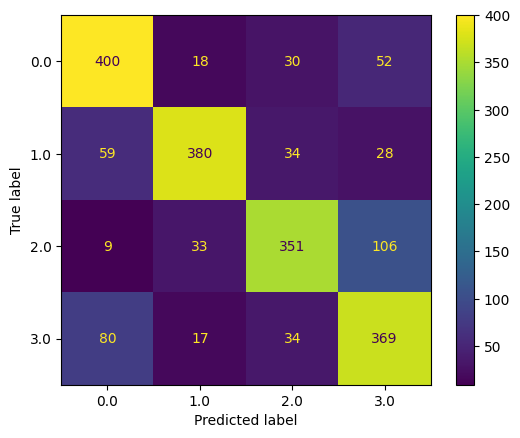

In [23]:
y_pred = sft_clf.predict(X_test)
plot_confusion_matrix(sft_clf, X_test, y_test, y_pred)

# 3. Train a DecisionTree model able to predict the Gormiti_Land class.

### Grid search with cross-validation in order to find the best parameters

In [24]:
param_grid = {'max_depth': [10, 20, 30, 50], "max_leaf_nodes":[100, 150, 200, 500], "min_samples_leaf":[5, 10, 25]}

tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs= jobs)
tree_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=10,
             param_grid={'max_depth': [10, 20, 30, 50],
                         'max_leaf_nodes': [100, 150, 200, 500],
                         'min_samples_leaf': [5, 10, 25]})

In [25]:
evaluatorclassifier(tree_clf, X_test, y_test, X_train, y_train)

Train set score: 0.86
Test set score: 0.81
Best parameters: {'max_depth': 30, 'max_leaf_nodes': 100, 'min_samples_leaf': 5}
Best cross-validation score: 0.80
f1 score: 0.81
Accuracy: 0.813
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       500
         1.0       0.83      0.82      0.82       501
         2.0       0.83      0.76      0.79       499
         3.0       0.77      0.83      0.80       500

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



### Apply the best parameter in the actual model that I will use in the future

In [26]:
best_tree_param = tree_clf.best_params_
tree_clf = DecisionTreeClassifier(max_depth =  best_tree_param["max_depth"], max_leaf_nodes =  best_tree_param["max_leaf_nodes"], min_samples_leaf =  best_tree_param["min_samples_leaf"])
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=30, max_leaf_nodes=100, min_samples_leaf=5)

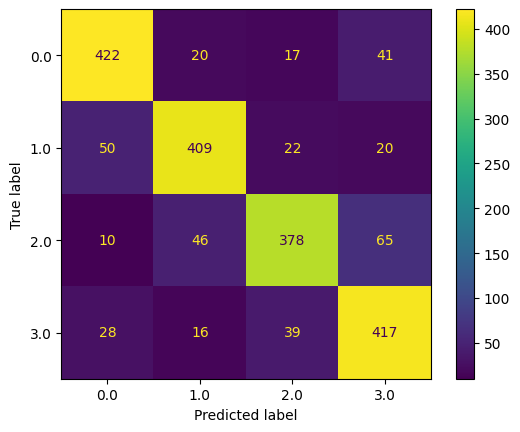

In [27]:
y_pred = tree_clf.predict(X_test)
plot_confusion_matrix(tree_clf, X_test, y_test, y_pred)

# 4. Train a Random Forest model able to predict the Gormiti_Land class.

### Grid search with cross-validation in order to find the best parameters

In [28]:
param_grid = {'max_depth': [10, 20, 30, 50], "max_leaf_nodes":[100, 150, 200, 500], "min_samples_leaf":[5, 10, 25]}
rnd_clf = GridSearchCV(RandomForestClassifier(n_estimators= 300, oob_score=True, bootstrap=True), param_grid, cv=5, n_jobs= jobs)
rnd_clf.fit(X_train, y_train)

In [ ]:
evaluatorclassifier(rnd_clf, X_test, y_test, X_train, y_train)

Train set score: 0.91
Test set score: 0.83
Best parameters: {'max_depth': 30, 'max_leaf_nodes': 500, 'min_samples_leaf': 5}
Best cross-validation score: 0.81
f1 score: 0.83
Accuracy: 0.826
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       500
         1.0       0.89      0.79      0.84       501
         2.0       0.84      0.74      0.79       499
         3.0       0.76      0.88      0.82       500

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



### Apply the best parameter in the actual model that I will use in the future

In [ ]:
best_param = rnd_clf.best_params_
rnd_clf = RandomForestClassifier(n_jobs=-1, max_depth =  best_param["max_depth"], max_leaf_nodes =  best_param["max_leaf_nodes"], min_samples_leaf =  best_param["min_samples_leaf"], n_estimators= 50, oob_score=True, bootstrap=True)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, max_leaf_nodes=500, min_samples_leaf=5,
                       n_estimators=50, n_jobs=-1, oob_score=True)

In [ ]:
rnd_clf.oob_score_

0.803482960516439

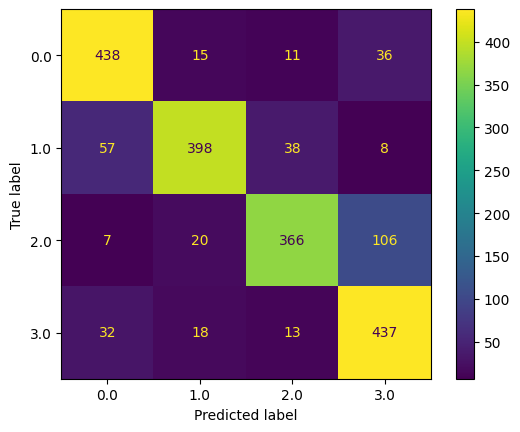

In [ ]:
y_pred = rnd_clf.predict(X_test)
plot_confusion_matrix(rnd_clf, X_test, y_test, y_pred)

## Visualizing the best 2 features

In [ ]:
def bestkfeature(df, model):
    ftr = {}

    for name, score in zip(df.columns, model.feature_importances_):
        ftr[name]= score
    k = 2
    res = {key: val for key, val in sorted(ftr.items(), key = lambda ele: ele[1], reverse = True)}
    res = dict(list(res.items())[0: k])
    return res

In [ ]:
print(bestkfeature(X_train, rnd_clf))

{'Against_Lava': 0.2538400505193794, 'Against_Fire': 0.19438183599301403}


In [ ]:
pred = rnd_clf.predict(X_val)
df_plot = pd.concat([X_val, y_val], axis=1)
df_plot["pred"] = pred
df_plot = df_plot[df_plot["Gormiti_Land"] == 2]
df_plot["Result"] = np.where(df_plot["Gormiti_Land"] == df_plot["pred"], "Right", "Wrong")
df_plot

,Gormiti_Type_Aoki,Gormiti_Type_Fearsome Darkens,Gormiti_Type_Fire,Gormiti_Type_Ice,Gormiti_Type_Lava,Gormiti_Type_Meka,Gormiti_Type_Rock,Gormiti_Type_Sea,Gormiti_Type_Wind,Nature_Evil,...,Deadly,Strength,Against_Fire,Against_Meka,Against_Lava,Against_Wind,Against_Rock,Gormiti_Land,pred,Result
2886,0,0,0,1,0,0,0,0,0,0,...,0.0,-0.3750,-0.817774,0.398469,-0.124797,-0.585851,0.395130,2.0,2.0,Right
7988,0,0,0,0,0,1,0,0,0,0,...,0.0,0.9375,-0.293500,0.563186,0.292037,-0.388495,0.563700,2.0,2.0,Right
6878,0,0,1,0,0,0,0,0,0,0,...,1.0,-0.7500,0.345965,-0.659773,0.933870,0.029078,0.236486,2.0,3.0,Wrong
3040,0,1,0,0,0,0,0,0,0,1,...,1.0,0.0625,-0.339686,1.256332,0.377922,-0.386724,0.749777,2.0,2.0,Right
5312,0,0,0,0,1,0,0,0,0,0,...,0.0,-0.1875,-0.057227,-0.294458,0.352610,0.273490,-0.120422,2.0,3.0,Wrong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0,0,0,0,0,0,0,0,1,0,...,1.0,-0.2500,-0.936511,0.293118,-0.199331,-0.180456,0.377607,2.0,2.0,Right
7425,0,1,0,0,0,0,0,0,0,0,...,0.0,-0.8125,-0.564887,-0.609817,-0.241742,-0.146677,-0.414990,2.0,2.0,Right
358,0,0,0,0,0,1,0,0,0,1,...,0.0,0.7500,-1.347478,-0.052499,-0.871448,-0.718096,-0.581549,2.0,2.0,Right
4662,0,0,0,0,0,0,0,0,1,0,...,1.0,0.6875,-1.628729,-1.068493,-1.235096,0.396755,-1.524841,2.0,2.0,Right


In [ ]:
fig = px.scatter(df_plot, x= "Against_Lava", y="Against_Rock", facet_col="Result")
fig

### da commentare

## Precision recall comparison

In [ ]:
""" from sklearn.metrics import precision_recall_curve
precision_rnd, recall_rnd = precision_recall_curve(y_test, rnd_clf.predict(X_test))
precision_tree, recall_tree = precision_recall_curve(y_test, tree_clf.predict(X_test)[:, 1])
precision_sft, recall_sft = precision_recall_curve(y_test, sft_clf.predict(X_test)[:, 1])
plt.plot(precision_rnd, recall_rnd, label="rnd")
plt.plot(precision_sft, recall_sft, label="sft")
plt.plot(precision_tree, recall_tree, label="tree")

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best") """

' from sklearn.metrics import precision_recall_curve\nprecision_rnd, recall_rnd = precision_recall_curve(y_test, rnd_clf.predict(X_test))\nprecision_tree, recall_tree = precision_recall_curve(y_test, tree_clf.predict(X_test)[:, 1])\nprecision_sft, recall_sft = precision_recall_curve(y_test, sft_clf.predict(X_test)[:, 1])\nplt.plot(precision_rnd, recall_rnd, label="rnd")\nplt.plot(precision_sft, recall_sft, label="sft")\nplt.plot(precision_tree, recall_tree, label="tree")\n\nplt.xlabel("Precision")\nplt.ylabel("Recall")\nplt.legend(loc="best") '

# 5. Train an AdaBoost model able to predict the Gormiti_Land class

### Apply the best parameter in the actual model that I will use in the future

In [ ]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth =  best_tree_param["max_depth"], max_leaf_nodes =  best_tree_param["max_leaf_nodes"], min_samples_leaf =  best_tree_param["min_samples_leaf"]), 
    n_estimators=50,
    algorithm="SAMME.R", 
    learning_rate=0.6)

ada_clf.fit(X_train, y_train)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20,
                                                    max_leaf_nodes=100,
                                                    min_samples_leaf=5),
                   learning_rate=0.6)

In [ ]:
evaluatorclassifier(ada_clf, X_test, y_test, X_train, y_train)

Train set score: 0.95
Test set score: 0.84
f1 score: 0.84
Accuracy: 0.843
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86       500
         1.0       0.88      0.83      0.86       501
         2.0       0.83      0.82      0.82       499
         3.0       0.80      0.86      0.83       500

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



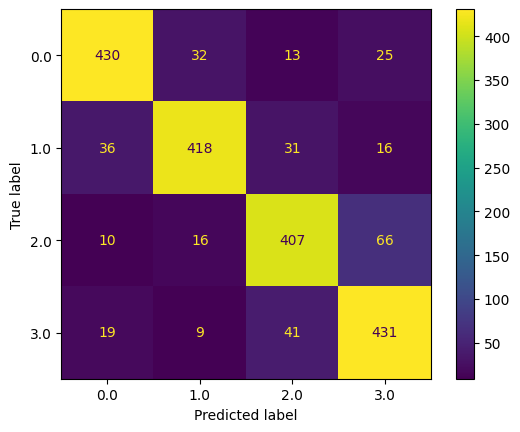

In [ ]:
y_pred = ada_clf.predict(X_test)
plot_confusion_matrix(ada_clf, X_test, y_test, y_pred)

In [ ]:
param_grid = {'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9], 'algorithm':["SAMME.R"], "n_estimators": [50, 100, 150], "estimator":[DecisionTreeClassifier(
    max_depth =  best_tree_param["max_depth"],
    max_leaf_nodes =  best_tree_param["max_leaf_nodes"],
    min_samples_leaf =  best_tree_param["min_samples_leaf"])]}
ada2 = GridSearchCV(AdaBoostClassifier(), param_grid, n_jobs=jobs)

In [ ]:
ada2.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=10,
             param_grid={'algorithm': ['SAMME.R'],
                         'estimator': [DecisionTreeClassifier(max_depth=20,
                                                              max_leaf_nodes=100,
                                                              min_samples_leaf=5)],
                         'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'n_estimators': [50, 100, 150]})

In [ ]:
evaluatorclassifier(ada2, X_test, y_test, X_train, y_train)

Train set score: 0.97
Test set score: 0.86
Best parameters: {'algorithm': 'SAMME.R', 'estimator': DecisionTreeClassifier(max_depth=20, max_leaf_nodes=100, min_samples_leaf=5), 'learning_rate': 0.7, 'n_estimators': 150}
Best cross-validation score: 0.86
f1 score: 0.86
Accuracy: 0.858
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       500
         1.0       0.89      0.84      0.86       501
         2.0       0.88      0.83      0.86       499
         3.0       0.81      0.88      0.84       500

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



# 6. Train a Soft Voting Classifier model able to predict the Gormiti_Land class.

In [ ]:
def ensableevaluator(model, X_test, y_test):
    y_class = model.predict(X_test)
    print("f1 score: {:.2f}".format(f1_score(y_test, y_class, average="weighted")))
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_class)))
    print("-----------------------------------------------------------")
    print(classification_report(y_test, y_class))

In [ ]:
voting_clf = VotingClassifier(estimators=[('ada', ada_clf), ('rf', rnd_clf), ('tre', tree_clf), ("sft", sft_clf)], voting='soft') ## we specify SOFT voting

voting_clf.fit(X_train, y_train)

for clf in (sft_clf, tree_clf, rnd_clf, ada_clf, voting_clf):
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.75
DecisionTreeClassifier 0.813
RandomForestClassifier 0.8195
AdaBoostClassifier 0.843
VotingClassifier 0.844


In [ ]:
ensableevaluator(voting_clf, X_test, y_test)

f1 score: 0.84
Accuracy: 0.844
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       500
         1.0       0.90      0.84      0.87       501
         2.0       0.88      0.77      0.82       499
         3.0       0.78      0.87      0.82       500

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.84      0.84      2000



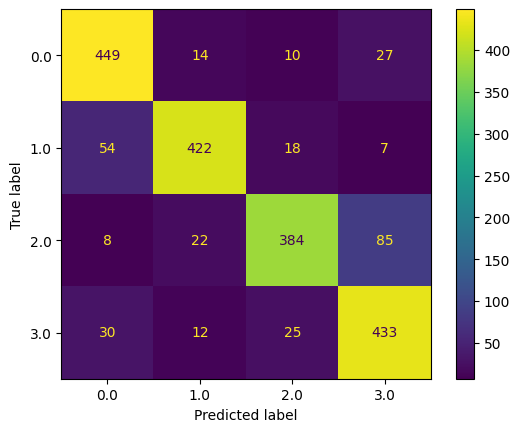

In [ ]:
y_pred = voting_clf.predict(X_test)
plot_confusion_matrix(voting_clf, X_test, y_test, y_pred)

# 7. Train a Blender classifier able to predict the Gormiti_Land class.

In [ ]:
def create_predictions(estimators, X_value):
    X_val_predictions = np.empty((len(X_value), len(estimators)), dtype=np.float32)

    for index, estimator in enumerate(estimators):
        X_val_predictions[:, index] = estimator.predict(X_value)
        
    return X_val_predictions

def blender_trainer(estimators, X_value, y_val):
    X_val_predictions = create_predictions(estimators, X_value)
    rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=22)
    rnd_forest_blender.fit(X_val_predictions, y_val)
    return rnd_forest_blender

In [ ]:
estimators = [sft_clf, rnd_clf, tree_clf, ada_clf]
blender_clf = blender_trainer(estimators, X_val, y_val)
blender_clf.oob_score_

0.8178137651821862

In [ ]:
tester = create_predictions(estimators, X_test)
ensableevaluator(blender_clf, tester, y_test)

f1 score: 0.85
Accuracy: 0.848
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       500
         1.0       0.87      0.86      0.87       501
         2.0       0.87      0.79      0.83       499
         3.0       0.79      0.87      0.83       500

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



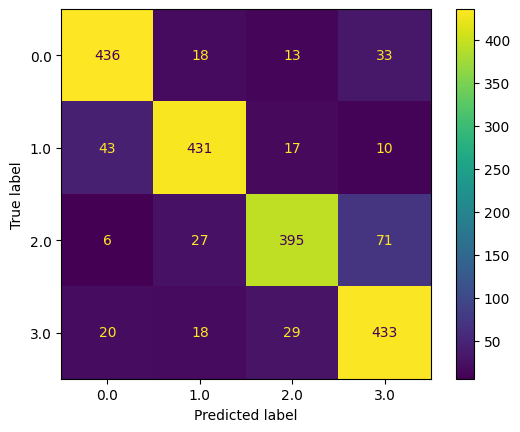

In [ ]:
tester = create_predictions(estimators, X_test)
y_pred = blender_clf.predict(tester)
plot_confusion_matrix(blender_clf, tester, y_test, y_pred)

# 8. Compare the performances of the previously trained classifiers and ensemble models evaluating them on the provided test set.

In [ ]:
for clf in (sft_clf, tree_clf, rnd_clf, ada_clf):
  print(clf.__class__.__name__)
  y_pred = clf.predict(X_test)
  evaluatorclassifier(clf, X_test, y_test, X_train, y_train)
  print("-----------------------------------------------------------")
for clf in (voting_clf, blender_clf):
  if isinstance(clf, VotingClassifier):
    print(clf.__class__.__name__)
    ensableevaluator(clf, X_test, y_test)
    print("-----------------------------------------------------------")
  else:
    print("BlenderClassifier")
    tester = create_predictions(estimators, X_test)
    ensableevaluator(blender_clf, tester, y_test)
    print("-----------------------------------------------------------")

LogisticRegression
Train set score: 0.75
Test set score: 0.75
f1 score: 0.75
Accuracy: 0.750
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76       500
         1.0       0.85      0.76      0.80       501
         2.0       0.78      0.70      0.74       499
         3.0       0.66      0.74      0.70       500

    accuracy                           0.75      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.75      0.75      2000

-----------------------------------------------------------
DecisionTreeClassifier
Train set score: 0.86
Test set score: 0.81
f1 score: 0.81
Accuracy: 0.813
-----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       500
         1.0       0.83      0.82      0.82       501
         2.0       0.83      0.7